In [1]:
import numpy as np
import pandas as pd 
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import os

2024-05-07 13:22:16.401649: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-07 13:22:16.401763: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-07 13:22:16.563012: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


"\nfor dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))\n"

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
df = pd.read_csv('/kaggle/input/butterfly-image-classification/Training_set.csv')
df.head()

,filename,label
0,Image_1.jpg,SOUTHERN DOGFACE
1,Image_2.jpg,ADONIS
2,Image_3.jpg,BROWN SIPROETA
3,Image_4.jpg,MONARCH
4,Image_5.jpg,GREEN CELLED CATTLEHEART


In [4]:
df['label'].nunique()

75

In [5]:
X = []
y = df['label'].values

y.shape

(6499,)

In [6]:
from sklearn.preprocessing import LabelEncoder

In [7]:
encoder = LabelEncoder()

y = encoder.fit_transform(y)

In [8]:
dir = '/kaggle/input/butterfly-image-classification/train'

for x in df['filename']:
    X.append(cv2.imread(os.path.join(dir, x)))
    
X = np.array(X)

X.shape

(6499, 224, 224, 3)

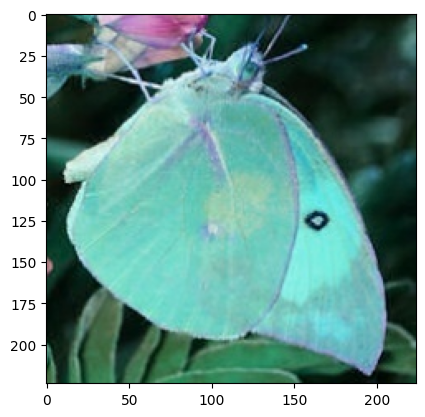

In [9]:
im = X[0]
plt.imshow(im)

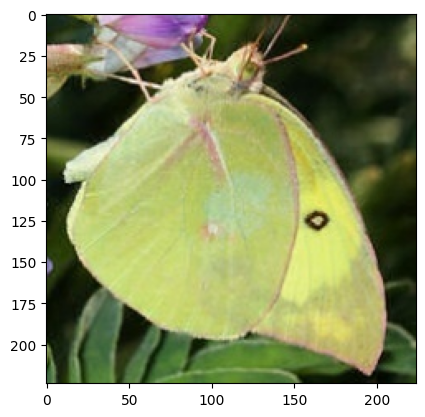

In [10]:
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.imshow(im)

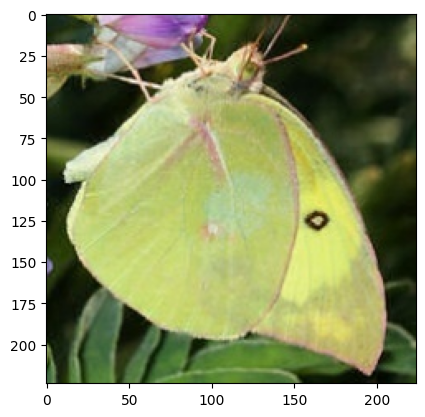

In [11]:
for i in range(X.shape[0]):
    X[i] = cv2.cvtColor(X[i], cv2.COLOR_BGR2RGB)  
plt.imshow(X[0])

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 42)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((5199, 224, 224, 3), (1300, 224, 224, 3), (5199,), (1300,))

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import Regularizer
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom, RandomContrast
from tensorflow.keras import regularizers

In [15]:
model = Sequential()

model.add(Rescaling(1 / 255, input_shape = (224, 224, 3)))

model.add(RandomFlip())
model.add(RandomRotation((-1, 1)))
model.add(RandomZoom(height_factor = 0.2, width_factor = 0.2))
model.add(RandomContrast(0.5))

model.add(Conv2D(16, (5, 5), activation = 'relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(32, (5, 5), activation = 'relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation = 'relu'))

model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(128, activation = 'relu', kernel_regularizer = tf.keras.regularizers.l1_l2()))
model.add(Dense(128, activation = 'relu', kernel_regularizer = tf.keras.regularizers.l1_l2()))
model.add(Dense(128, activation = 'relu', kernel_regularizer = tf.keras.regularizers.l1_l2()))

model.add(Dropout(0.2))

model.add(Dense(75, activation = 'softmax'))

model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:18: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip (RandomFlip)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 224, 224, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom (RandomZoom)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast                 │ (None, 224, 224, 3)    │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 220, 220, 16)   │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 110, 110, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 106, 106, 32)   │        12,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 53, 53, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 51, 51, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 23, 23, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 23, 23, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 67712)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     8,667,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 75)             │         9,675 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,816,363 (33.63 MB)

 Trainable params: 8,816,363 (33.63 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
model.compile(optimizer = 'adam', loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [17]:
hst = model.fit(X_train, y_train, epochs = 100, batch_size = 32, validation_data = (X_val, y_val))

Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/nn.py:625: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
2024-05-07 13:23:50.711895: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/sequential_1/dropout_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


163/163 ━━━━━━━━━━━━━━━━━━━━ 19s 62ms/step - accuracy: 0.0141 - loss: 4.3163 - val_accuracy: 0.0285 - val_loss: 4.1603
Epoch 2/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.0363 - loss: 4.0813 - val_accuracy: 0.0692 - val_loss: 3.8261
Epoch 3/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.0646 - loss: 3.8289 - val_accuracy: 0.0938 - val_loss: 3.5882
Epoch 4/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 8s 48ms/step - accuracy: 0.0890 - loss: 3.5724 - val_accuracy: 0.1462 - val_loss: 3.3970
Epoch 5/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms/step - accuracy: 0.1300 - loss: 3.3599 - val_accuracy: 0.1531 - val_loss: 3.2060
Epoch 6/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms/step - accuracy: 0.1651 - loss: 3.2036 - val_accuracy: 0.1585 - val_loss: 3.1364
Epoch 7/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms/step - accuracy: 0.1989 - loss: 2.9879 - val_accuracy: 0.2608 - val_loss: 2.7166
Epoch 8/100
163/163 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step - accuracy: 0.2425 - loss: 2.8687 - val_accurac

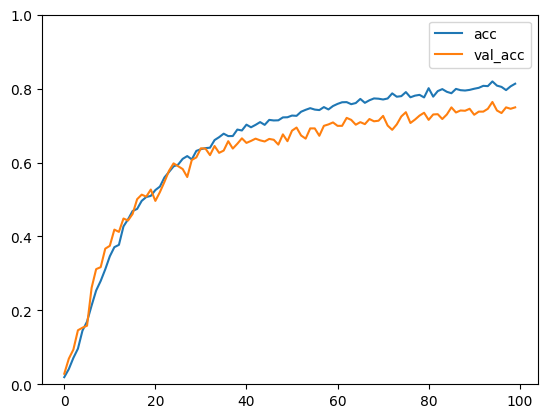

In [18]:
acc = hst.history['accuracy']
val_acc = hst.history['val_accuracy']
n = len(acc)

plt.ylim(0.0, 1.0)

plt.plot(acc, label='acc')
plt.plot(val_acc, label='val_acc')
plt.legend()

In [19]:
model.evaluate(X_train, y_train)

163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8714 - loss: 0.3748


[0.36548686027526855, 0.8736295700073242]

In [20]:
model.evaluate(X_val, y_val)

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7393 - loss: 1.1996


[1.1348750591278076, 0.7492307424545288]